In [1]:
from nmf_md import *

import timeit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sps

In [2]:
# Test dataset generation
#fac = 10
#d = 5

#np.random.seed(42)
#M = np.random.rand(5 * fac, 10 * fac)
#w_0 = np.random.rand(5 * fac, d)
#h_0 = np.random.rand(d, 10 * fac)

## Test dataset loading and matrix initialization

In [3]:
df = pd.read_csv('converted.csv')
format_size = 4

M = df.to_numpy().astype('float32')
M /= 5
print(f"Size of M: {(M.size * format_size)/1000_000:.2f} MB")

d = 100
m, n = M.shape
w_0 = np.random.rand(m, d)
h_0 = np.random.rand(d, n)

M_md = sps.csr_matrix(M, dtype='float32')
print(isinstance(M_md, sps.csr_matrix))
print(f"Size of M_md: {(len(M_md.indptr) * 8 + len(M_md.indices) * 8 + len(M_md.data) * format_size)/1000_000:.2f} MB")

Size of M: 88.81 MB
True
Size of M_md: 9.03 MB


Setup parameters for the algorithm
- steps: iterations of the outer loop
- delta: minimum value in W, H --> 0 for base NMF
- error: error function for logging (can be replaced by any function accepting 2 matrices as input)

In [4]:
# Algorithm parameters
steps = 100
delta = 0

Setup variables for algorithm execution
- Create copies of initialized W, H for repetetive tests with the same starting points
- Create logging dictionaries that will log time and error

In [5]:
# Variable setup
Ws, Hs = [], []
for i in range(2):
    Ws.append(np.copy(w_0))
    Hs.append(np.copy(h_0))

log_1 = {}
log_2 = {}

#_, _, c_1 = NMF(M, Ws[0], Hs[0], mu_w, mu_h, delta, steps, 'rmse', log_1)
_, _, c_1 = NMF_md(M, Ws[0], Hs[0], mu_w, mu_h, delta, steps, 'rmse', log_1)
_, _, c_2 = NMF_md(M_md, Ws[1], Hs[1], mu_w, mu_h, delta, steps, 'rmse', log_2)


Repeat same setup for timed execution of the functions
- n: number of executions of each algorithm to be performed

In [8]:
# Variable setup for timing
Ws, Hs = [], []
for i in range(2):
    Ws.append(np.copy(w_0))
    Hs.append(np.copy(h_0))

n = 1

result = [0, 0]
result[0] = timeit.timeit(stmt="NMF(M, Ws[0], Hs[0], mu_w, mu_h, delta, steps, 'error')", globals=globals(), number=n)
result[1] = timeit.timeit(stmt="NMF_md(M_md, Ws[1], Hs[1], mu_w, mu_h, delta, steps, 'error')", globals=globals(), number=n)


## Results
Print some of the collected results (mainly for debugging and verification)

In [9]:
# Print Error Development
for i, (l1, l2) in enumerate(zip(log_1, log_2)):
    print(f"Step {i:3d}: MU {log_1[l1]:.5f}, MU_md {log_2[l2]:.5f}")

print()

# Print total updates for W and H
for i in ['w', 'h']:
    print(f"Mat. [{i}]: MU {c_1[i]:4d}, MU_md {c_2[i]:4d}")

print()

# Print execution times in ms
print(f"Times: MU {result[0]/n:.2f}s, MU_md {result[1]/n:.2f}s")

Step   0: MU 25.08071, MU_md 24.36622
Step   1: MU 0.12428, MU_md 0.62723
Step   2: MU 0.12392, MU_md 0.62215
Step   3: MU 0.12384, MU_md 0.62133
Step   4: MU 0.12374, MU_md 0.62051
Step   5: MU 0.12362, MU_md 0.61946
Step   6: MU 0.12343, MU_md 0.61799
Step   7: MU 0.12316, MU_md 0.61578
Step   8: MU 0.12273, MU_md 0.61232
Step   9: MU 0.12207, MU_md 0.60698
Step  10: MU 0.12113, MU_md 0.59934
Step  11: MU 0.12000, MU_md 0.59009
Step  12: MU 0.11885, MU_md 0.58079
Step  13: MU 0.11779, MU_md 0.57238
Step  14: MU 0.11684, MU_md 0.56506
Step  15: MU 0.11600, MU_md 0.55877
Step  16: MU 0.11525, MU_md 0.55336
Step  17: MU 0.11459, MU_md 0.54868
Step  18: MU 0.11400, MU_md 0.54459
Step  19: MU 0.11347, MU_md 0.54098
Step  20: MU 0.11299, MU_md 0.53778
Step  21: MU 0.11256, MU_md 0.53492
Step  22: MU 0.11217, MU_md 0.53235
Step  23: MU 0.11181, MU_md 0.53003
Step  24: MU 0.11149, MU_md 0.52793
Step  25: MU 0.11118, MU_md 0.52602
Step  26: MU 0.11090, MU_md 0.52428
Step  27: MU 0.11065, MU_m

### Graph generation
Plot recorded outputs on a graph that is X and Y limited to the interesting region for visibility

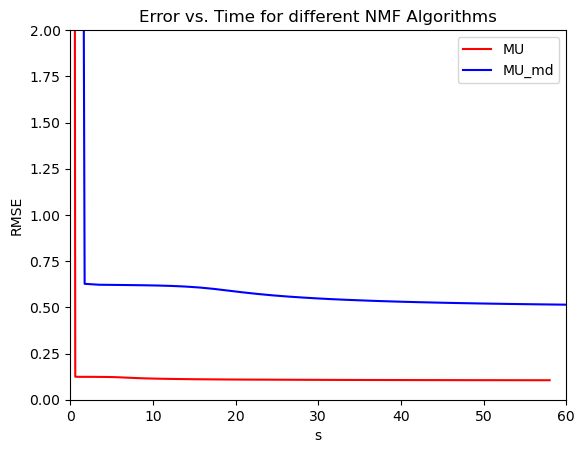

In [13]:
time_0, time_1, time_2, time_3 = [], [], [], []
errs_0, errs_1, errs_2, errs_3 = [], [], [], []

for i, k in enumerate(log_1):
    time_0.append(k)
    errs_0.append(log_1[k])
time_0 = [x - time_0[0] for x in time_0]
    
for i, k in enumerate(log_2):
    time_1.append(k)
    errs_1.append(log_2[k])
time_1 = [x - time_1[0] for x in time_1]


plt.plot(time_0, errs_0, 'r', label='MU')
plt.plot(time_1, errs_1, 'b', label='MU_md')
#plt.yscale('log')
#plt.xscale('log')
plt.xlim([0, 60])
plt.ylim([0, 2])
plt.ylabel('RMSE')
plt.xlabel('s')
plt.title('Error vs. Time for different NMF Algorithms')
plt.legend()
plt.show()
